In [ ]:
# TODO:
# Interesting examples to pull out (preds are different btwn CFQI and FQI) 
#install jax with 
# exit()


In [1]:
import json
import sys
import jax.numpy as jnp
import seaborn as sns
import tqdm
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.optim as optim
from sklearn.ensemble import ExtraTreesRegressor, ExtraTreesClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
import itertools
import pandas as pd
import pickle
import math
import torch 
import torch.optim as optim
from sklearn.metrics import mean_squared_error
import jax.random as random
from typing import List, Tuple
import gym
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from agents import NFQAgent
from networks import NFQNetwork
import os
platform = 'local' ## Change this to local when using your local computer

/usr/licensed/anaconda3/2021.11/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from multigroupGP import GP, MultiGroupRBF, RBF
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

In [3]:
data_path = 'mimic_iv/'
group0_test_Ktuples = pickle.load(open(data_path + 'group_0_GroupedtestKtuples.pkl', 'rb'))
group0_train_Ktuples  = pickle.load(open(data_path + 'group_0_GroupedtrainKtuples.pkl', 'rb'))
group1_test_Ktuples  = pickle.load(open(data_path + 'group_1_GroupedtestKtuples.pkl', 'rb'))
group1_train_Ktuples = pickle.load(open(data_path + 'group_1_GroupedtrainKtuples.pkl', 'rb'))
group2_test_Ktuples  = pickle.load(open(data_path + 'group_2_GroupedtestKtuples.pkl', 'rb'))
group2_train_Ktuples = pickle.load(open(data_path + 'group_2_GroupedtrainKtuples.pkl', 'rb'))
group3_test_Ktuples  = pickle.load(open(data_path + 'group_3_GroupedtestKtuples.pkl', 'rb'))
group3_train_Ktuples = pickle.load(open(data_path + 'group_3_GroupedtrainKtuples.pkl', 'rb'))
group4_test_Ktuples  = pickle.load(open(data_path + 'group_4_GroupedtestKtuples.pkl', 'rb'))
group4_train_Ktuples = pickle.load(open(data_path + 'group_4_GroupedtrainKtuples.pkl', 'rb'))
group5_test_Ktuples  = pickle.load(open(data_path + 'group_5_GroupedtestKtuples.pkl', 'rb'))
group5_train_Ktuples = pickle.load(open(data_path + 'group_5_GroupedtrainKtuples.pkl', 'rb'))
group6_test_Ktuples  = pickle.load(open(data_path + 'group_6_GroupedtestKtuples.pkl', 'rb'))
group6_train_Ktuples = pickle.load(open(data_path + 'group_6_GroupedtrainKtuples.pkl', 'rb'))

In [4]:
def generate_rollout(vnum, tuples, group=0):
    trajectory = []
    for i in range(len(tuples['vnum'])):
        vn = tuples['vnum'][i]
        if str(vn) == str(vnum):
            s = tuples['s'][i]
            a = tuples['a'][i]
            if sum(a) > 1:
                pass
            a = np.where(a==1)[0][0]
            if a == 0:
                a = [0, 0]
            elif a in [1, 2, 3, 7, 8]:
                a = [0, 10]
            else:
                a = [10, 0]
            ns = tuples['ns'][i]
            r = tuples['r'][i]
            
            trajectory.append((s, a, r, ns, False, group))
    
    last_tuple = trajectory[-1]
    new_last_tuple = (last_tuple[0], last_tuple[1], last_tuple[2], last_tuple[3], True, group)
    trajectory = trajectory[:-1]
    trajectory.append(new_last_tuple)
    return trajectory

def rollout_dataset(ds='train', env='g0', init_experience=10):
    groups = {'g0': group0_train_Ktuples, 'g1': group1_train_Ktuples, 'g2': group2_train_Ktuples, 'g3': group3_train_Ktuples, 'g4': group4_train_Ktuples, 'g5': group5_train_Ktuples, 'g6': group6_train_Ktuples}
    if ds == 'test':
        groups = {'g0': group0_test_Ktuples, 'g1': group1_test_Ktuples, 'g2': group2_test_Ktuples, 'g3': group3_test_Ktuples, 'g4': group4_test_Ktuples, 'g5': group5_test_Ktuples, 'g6': group6_test_Ktuples}
    rollout = []
    for vnum in groups[env]['vnum'][:init_experience]:
        traj = generate_rollout(vnum, groups[env], group=int(env[1]))
        rollout.extend(traj)
    return rollout

def normalize_rollouts(rollouts):
    min_r = min([r[2] for r in rollouts])
    max_r = max([r[2] for r in rollouts])
    new_rollout = []
    for r in rollouts:
        new_reward = (r[2] - min_r)/(max_r - min_r)
        new_rollout.append((r[0], r[1], new_reward, r[3], r[4], r[5]))
    
    sns.distplot([r[2] for r in new_rollout])
    return new_rollout

In [5]:
# is_contrastive=True
# verbose = True
# init_experience = 100
# # A set of transition tuples. Male is background, female is foreground. 
# # bg_rollouts = rollout_dataset(ds='train', env='bg', init_experience=init_experience)
# # fg_rollouts = rollout_dataset(ds='train', env='fg', init_experience=init_experience)
# g0_rollouts = rollout_dataset(ds='train', env='g0', init_experience=init_experience)
# g1_rollouts = rollout_dataset(ds='train', env='g1', init_experience=init_experience)
# g2_rollouts = rollout_dataset(ds='train', env='g2', init_experience=init_experience)
# g3_rollouts = rollout_dataset(ds='train', env='g3', init_experience=init_experience)
# g4_rollouts = rollout_dataset(ds='train', env='g4', init_experience=init_experience)
# g5_rollouts = rollout_dataset(ds='train', env='g5', init_experience=init_experience)
# g6_rollouts = rollout_dataset(ds='train', env='g6', init_experience=init_experience)

# g0_rollouts.extend(g1_rollouts)
# g0_rollouts.extend(g2_rollouts)
# g0_rollouts.extend(g3_rollouts)
# g0_rollouts.extend(g4_rollouts)
# g0_rollouts.extend(g5_rollouts)
# g0_rollouts.extend(g6_rollouts)

# all_rollouts = g0_rollouts.copy()
# all_rollouts = normalize_rollouts(all_rollouts)
# pickle.dump(all_rollouts, open(data_path + '/mimic_iv/all_rollouts.pkl', 'wb'))

In [5]:
# load all rollouts
all_rollouts = pickle.load(open(data_path + 'all_rollouts.pkl', 'rb'))


In [6]:
len(all_rollouts[0])

6

In [7]:
class Agent:
    def __init__(self, nfq_net: nn.Module, optimizer: optim.Optimizer, random_seed: int = 0,
                    dir: str = "model", mode: str = "nfq", verbose: bool = False):
        """
        :param nfq_net: NFQ network
        :param optimizer: optimizer
        :param random_seed: random seed
        :param dir: directory to save the model
        :param mode: either "nfq" or "mggp"
        :param verbose: verbose
        """
        self.nfq_net = nfq_net
        self.optimizer = optimizer
        self.random_seed = random_seed
        self.dir = dir
        self.mode = mode
        self.verbose = verbose
        self.trained = False
        if self.mode == "mggp":
            self.RANDOM_SEED = 0
            self.key = random.PRNGKey(self.RANDOM_SEED)
            self.kernel = MultiGroupRBF()
            self.gp_q_est = GP(self.kernel, key = self.key, is_mggp=True)
        elif self.mode == "gp":
            self.RANDOM_SEED = 0
            self.kernel = DotProduct() + WhiteKernel()
            self.gp_q_est = GaussianProcessRegressor(kernel=self.kernel, alpha=1e-10, 
                                    n_restarts_optimizer=10, random_state=self.RANDOM_SEED)
        
    def get_best_action(self, obs: np.ndarray, unique_actions: np.ndarray, group: np.ndarray) -> int:
        """
        :param obs: observation
        :param unique_actions: unique actions
        :param group: group
        :return: best action
        """
        q_list = np.zeros(len(unique_actions))
        if self.mode == "nfq":
            for ii, action in enumerate(unique_actions):
                q = self.nfq_net(
            torch.cat([torch.FloatTensor(obs), torch.FloatTensor(action)], dim=0))
                q_list[ii] = q
        elif self.mode == "mggp":
            if self.trained:
                obs = jnp.array(obs)
                for ii, action in enumerate(unique_actions):
                    x = jnp.concatenate([obs, action])
                    x = x.reshape(1, -1)
                    q = self.gp_q_est.predict(x, group)
                    q_list[ii] = q
            else:
                raise ValueError("Model not trained yet!")
        elif self.mode == "gp":
            if self.trained:
                obs = np.array(obs)
                for ii, action in enumerate(unique_actions):
                    x = np.concatenate([obs, action])
                    x = x.reshape(1, -1)
                    q = self.gp_q_est.predict(x)
                    q_list[ii] = q
            else:
                raise ValueError("Model not trained yet!")
        return unique_actions[np.argmin(q_list)]

    def train(self, pattern_set: tuple) -> float:
        if self.mode == "nfq":
            state_action_b, target_q_values, group_b = pattern_set
            predicted_q_values = self.nfq_net(state_action_b).squeeze()
            loss = torch.nn.functional.mse_loss(predicted_q_values, target_q_values)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        
        elif self.mode == "mggp":
            x, y, group = pattern_set
            x, y, group = jnp.array(x), jnp.array(y), jnp.array(group)
            x_train, x_test, y_train, y_test, group_train, group_test = train_test_split(x, y, group, test_size=0.05, random_state=self.RANDOM_SEED)
            x_test, _ , y_test, _ , group_test, _ = train_test_split(x_test, y_test, group_test, test_size=0.05, random_state=self.RANDOM_SEED)
            self.gp_q_est.fit(x_train, y_train, group_train)
            loss = mean_squared_error(y_test, self.gp_q_est.predict(x_test, group_test))
            self.trained = True

        elif self.mode == "gp":
            x, y, _ = pattern_set
            x, y = np.array(x), np.array(y)
            x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05, random_state=self.RANDOM_SEED)
            x_test, _ , y_test, _ = train_test_split(x_test, y_test, test_size=0.05, random_state=self.RANDOM_SEED)
            self.gp_q_est.fit(x_train, y_train)
            loss = mean_squared_error(y_test, self.gp_q_est.predict(x_test))
            self.trained = True

        return loss

    def save_model(self):
        if not os.path.exists(self.dir):
            os.makedirs(self.dir)
        if self.mode == "nfq":
            torch.save(self.nfq_net.state_dict(), self.dir + "/nfq_net.pt")
        elif self.mode == "mggp":
            pickle.dump(self.gp_q_est, open(self.dir + "/mggp_net.pkl", "wb"))
        elif self.mode == "gp":
            pickle.dump(self.gp_q_est, open(self.dir + "/gp_net.pkl", "wb"))

    def load_model(self):
        if self.mode == "nfq":
            self.nfq_net.load_state_dict(torch.load(self.dir + "/nfq_net.pt"))
        elif self.mode == "mggp":
            self.gp_q_est = pickle.load(open(self.dir + "/mggp_net.pkl", "rb"))
            self.trained = True
        elif self.mode == "gp":
            self.gp_q_est = pickle.load(open(self.dir + "/gp_net.pkl", "rb"))
            self.trained = True

    def generate_pattern_set(self, rollouts, gamma: float = 0.95, mode="nfq"):
        """
        Generate pattern set from rollouts
        """
        state_b, action_b, reward_b, next_state_b, done_b, group_b = zip(*rollouts)
        if self.mode == "nfq":
            state_b = torch.FloatTensor(state_b)
            action_b = torch.FloatTensor(action_b)
            cost_b = torch.FloatTensor(reward_b)
            next_state_b = torch.FloatTensor(next_state_b)
            done_b = torch.FloatTensor(done_b)
            group_b = torch.LongTensor(group_b)
            state_action_b = torch.cat([state_b, action_b], dim=1)
            group_b = group_b.resize(len(group_b), 1)

            next_state_left = torch.cat([next_state_b, torch.zeros(len(rollouts), 1), group_b], 1)
            next_state_right = torch.cat([next_state_b, torch.ones(len(rollouts), 1), group_b], 1)

            q_next_state_left_b = self.nfq_net(next_state_left).squeeze()
            q_next_state_right_b = self.nfq_net(next_state_right).squeeze()
            q_next_state_b = torch.min(q_next_state_left_b, q_next_state_right_b)
            
            with torch.no_grad():
                target_q_values = cost_b + gamma * q_next_state_b * (1 - done_b)
        
        elif self.mode == "mggp":
            state_b = jnp.array(state_b)
            action_b = jnp.array(action_b)
            cost_b = jnp.array(cost_b)
            next_state_b = jnp.array(next_state_b)
            done_b = jnp.array(done_b)
            group_b = jnp.array(group_b)
            state_action_b = jnp.column_stack([state_b, action_b])
            q_values = jnp.zeros(3)
            for i in range(3):
                q_next_state = self.gp_q_est.predict(jnp.append(state_b, action_b), group_test = group_b)
                q_values[i] = q_next_state
            
            q_next_state_b = jnp.min(q_values)

            target_q_values = cost_b + gamma * q_next_state_b * (1 - done_b)

        elif self.mode == "gp":
            state_b = jnp.array(state_b)
            action_b = jnp.array(action_b)
            cost_b = jnp.array(cost_b)
            next_state_b = jnp.array(next_state_b)
            done_b = jnp.array(done_b)
            group_b = jnp.array(group_b)
            state_action_b = jnp.column_stack([state_b, action_b])       
            q_values = jnp.zeros(3)
            for i in range(3):
                q_next_state = self.gp_q_est.predict(jnp.append(state_b, action_b))
                q_values[i] = q_next_state
            
            q_next_state_b = jnp.min(q_values)

            target_q_values = cost_b + gamma * q_next_state_b * (1 - done_b)

        return state_action_b, target_q_values, group_b

    def get_action(self, state, group, mode="nfq"):
        """
        Get action from state
        """
        if mode == "nfq":
            state = torch.FloatTensor(state)
            group = torch.LongTensor(group)
            group = group.resize(1, 1)
            state_left = torch.cat([state, torch.zeros(1, 1), group], 1)
            state_right = torch.cat([state, torch.ones(1, 1), group], 1)
            q_left = self.nfq_net(state_left, group).squeeze()
            q_right = self.nfq_net(state_right, group).squeeze()
            action = torch.argmax(torch.cat([q_left, q_right], dim=0))
        elif mode == "mggp":
            state = jnp.array(state)
            group = jnp.array(group)
            q_values = jnp.zeros(3)
            for i in range(3):
                q_values[i] = self.gp_q_est.predict(jnp.append(state, i), group_test = group)
            action = jnp.argmin(q_values)
        elif mode == "gp":
            state = jnp.array(state)
            group = jnp.array(group)
            q_values = jnp.zeros(3)
            for i in range(3):
                q_values[i] = self.gp_q_est.predict(jnp.append(state, i))
            action = jnp.argmin(q_values)

        return action


    def evaluate(self, eval_env: gym.Env, render=bool) -> Tuple[int, str, float]:
        """
        Evaluate the agent
        """
        episode_length = 0
        obs = eval_env.reset()
        done = False
        info = {"time_limit": False}
        episode_cost = 0
        while not done and not info["time_limit"]:
            action = self.get_best_action(obs)
            obs, cost, done, info = eval_env.step(action)
            episode_cost += cost
            episode_length += 1

            if render:
                eval_env.render()

        success = (
            episode_length == eval_env.max_steps
            and abs(obs[0]) <= eval_env.x_success_range
        )
        return episode_length, "success" if success else "failure", episode_cost






           
        


In [8]:
nfq_net_mggp = NFQNetwork()
optimizer = optim.Rprop(nfq_net_mggp.parameters())
mpp_agent = Agent( nfq_net_mggp, optimizer, 24, dir="", mode="nfq")

In [9]:
state_action_b, target_q_values, groups = mpp_agent.generate_pattern_set(all_rollouts)

/tmp/ipykernel_3989651/2910284219.py:120: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  state_b = torch.FloatTensor(state_b)
/home/pe3955/.local/lib/python3.9/site-packages/torch/_tensor.py:761: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [14]:
#
import tqdm
nfq_net_mggp = NFQNetwork()
optimizer = optim.Rprop(nfq_net_mggp.parameters(), lr=0.01)
mpp_agent = Agent( nfq_net_mggp, optimizer, 24, mode="nfq")
previous_loss = None
delta = 5e-5
count_fg = 0
count_bg = 0
bg_converged = False
fg_converged = False

losses = []
epoch = 100
mode = "nfq"
for k, epoch in enumerate(tqdm(range(epoch + 1))):
    state_action_b, target_q_values, groups = mpp_agent.generate_pattern_set(all_rollouts, mode=mode)
    loss_nfq = mpp_agent.train((state_action_b, target_q_values, groups))
    loss = loss_nfq.detach().numpy()
    losses.append(loss)

   
plt.plot(losses)    
    
    




TypeError: 'module' object is not callable

# Evaluation
* The optimal levels for K are between 3.5 and 4.5

In [11]:
def state_invtransformer(tstates, transformer='transformer.pkl'):
    
    scaler = pickle.load(open(transformer, 'rb'))
    states = scaler.inverse_transform(tstates)
    
    return states

In [42]:
state_feats = ['anchor_age', 'patientweight',
       'ethnicity', 'los', 'gender', 'dod', 'cad', 'afib', 'chf', 'ckd',
       'esrd', 'paralysis', 'parathyroid', 'rhabdo', 'sarcoid', 'sepsis',
       'dialysis', 'hypokalemia', 'Hyperkalemia', 'Obesity', 'cancer',
       'asthma', 'pneumonia', 'diabetics', 'HIV', 'bpdia', 'bpsys', 'hr', 'rr',
       'spo2', 'temp', 'alt', 'aniongap', 'bun', 'cpk', 'ca', 'chloride',
       'creatinine', 'glucose', 'hgb', 'k', 'ldh', 'mg', 'na', 'p', 'wbc',
       'betablockers', 'ca-iv', 'ca-noniv', 'cablockers', 'dextrose',
       'hours-dextrose', 'fluids', 'insulin', 'k-iv', 'k-noniv',
       'loopdiuretics', 'hours-loopdiuretics', 'mg-iv', 'mg-noniv',
       'hours-mg-noniv', 'p-iv', 'p-noniv', 'pnutrition', 'ponutrition',
       'tpnutrition', 'vasopressors', 'hours-betablockers', 'hours-cablockers',
       'hours-insulin', 'hours-k-iv', 'hours-ca-noniv', 'hours-vasopressors',
       'hours-pnutrition', 'hours-tpnutrition', 'hours-p-iv',
       'hours-ponutrition', 'hours-fluids', 'hours-ca-iv', 'hours-mg-iv']

# Heatmap of Actions

In [64]:
import json
def gather_repletion_levels(group_tuple, groupp=1, doctor=False, num_samples=20, r_size= 10,
                           start=0):
    no_repletion = []
    lo_repletion = []
    hi_repletion = []
    c_levels = []
    group = groupp
    tuples = group_tuple
    end = start + num_samples
    dir_ = "data/"
    filename = f"{start}_{end}_set.pkl"

    ## This for loop should run "num_sample x r_size" times. 
    # We need to determine how to get meaniful plot by tweaking r_size and num_samples
    ## R_size which is the rollout size varies from sample to samples. It is not fixed
    n = 0
    for j, vn in enumerate(tqdm.tqdm(tuples['vnum'][start:end])): ## Sample any "num of samples within the tuple list
        rollout = generate_rollout(vn, tuples, group=group)
        states = [r[0] for r in rollout[0:r_size]] ## Get "r_size number of states"
        k_measurement_ind = state_feats.index('k')
        c_ind = state_feats.index('creatinine')
        doctors_actions = [r[1] for r in rollout[0:r_size]]
        actions = np.asarray([[0, 0], [0, 10], [10, 0]])
        m = 0
        for s in states:
            s_ = s.reshape(1,-1)
            transformed_state = state_invtransformer(s_)
            transformed_state = transformed_state.reshape(-1,1)
            k = transformed_state[k_measurement_ind]
            creatinine = transformed_state[c_ind]
            c_levels.append(creatinine)
            a = mpp_agent.get_best_action(s, actions, group=group)
            a = list(a)
            # print(f"action for state {j} = {a} --- {n} --- {m}")
        
            if a == [0, 0]:
                no_repletion.append((creatinine, k))
            elif a == [0, 10]:
                lo_repletion.append((creatinine, k))
            elif a == [10, 0]:
                hi_repletion.append((creatinine, k))
            m = m + 1  
        n += 1
    c_levels = [i for i in range(0, 11)]
    measurements = [i/10 for i in range(26, 75)]
    viz = np.zeros((len(c_levels), len(measurements)))
    counts = np.zeros((len(c_levels), len(measurements)))
    for (c, measurement) in no_repletion:
        measurement = round(measurement[0], 1)
#         c = round(c, 0)
        c = round(c[0], 0)
        c = c_levels.index(c)
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 0
        counts[c, new_meas] += 1
    for (c, measurement) in lo_repletion:
#         measurement = round(measurement, 1)
#         c = round(c, 0)
        measurement = round(measurement[0], 1)
#         c = round(c, 0)
        c = round(c[0], 0)
        c = c_levels.index(c)
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 1
        counts[c, new_meas] += 1
    for (c, measurement) in hi_repletion:
#         measurement = round(measurement, 1)
#         c = round(c, 0)
        measurement = round(measurement[0], 1)
#         c = round(c, 0)
        c = round(c[0], 0)
        c = c_levels.index(c)
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 2
        counts[c, new_meas] += 1

    viz = np.divide(viz, counts, out=np.full_like(viz, np.nan), where=counts!=0)
    data = {"viz":viz.tolist(), "measurements":measurements, "c_levels":c_levels}
    
    return viz, measurements, c_levels

In [86]:
import json
from tqdm import tqdm
import numpy as np

def gather_repletion_levels(group_tuple, groupp=1, doctor=False, num_samples=20, r_size=10, start=0):
    no_repletion = []
    lo_repletion = []
    hi_repletion = []
    c_levels = list(range(0, 11))
    measurements = [i/10 for i in range(26, 75)]
    viz = np.zeros((len(c_levels), len(measurements)))
    counts = np.zeros((len(c_levels), len(measurements)))
    group = groupp
    tuples = group_tuple
    end = start + num_samples

    k_measurement_ind = state_feats.index('k')
    c_ind = state_feats.index('creatinine')
    actions = np.asarray([[0, 0], [0, 10], [10, 0]])

    for j, vn in enumerate(tqdm(tuples['vnum'][start:end])):
        rollout = generate_rollout(vn, tuples, group=group)
        states = [r[0] for r in rollout[0:r_size]]
        doctors_actions = [r[1] for r in rollout[0:r_size]]
        for s in states:
            s_ = s.reshape(1,-1)
            transformed_state = state_invtransformer(s_)
            k = transformed_state[k_measurement_ind]
            creatinine = transformed_state[c_ind]
            a = mpp_agent.get_best_action(s, actions, group=group)
            a = list(a)
        
            if a == [0, 0]:
                no_repletion.append((creatinine, k))
            elif a == [0, 10]:
                lo_repletion.append((creatinine, k))
            elif a == [10, 0]:
                hi_repletion.append((creatinine, k))
            
    for (c, measurement) in no_repletion:
        measurement = round(measurement[0], 1)
        c = round(c[0], 0)
        c = c_levels.index(c)
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 0
        counts[c, new_meas] += 1
    for (c, measurement) in lo_repletion:
        measurement = round(measurement[0], 1)
        c = round(c[0], 0)
        c = c_levels.index(c)
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 1
        counts[c, new_meas] += 1
    for (c, measurement) in hi_repletion:
        measurement = round(measurement[0], 1)
        c = round(c[0], 0)
        c = c_levels.index(c)        
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 2
        counts[c, new_meas] += 1
    return viz, measurements, c_levels



In [87]:
# n = 0
# tuples = group1_test_Ktuples
# start, end = 0, 3
# r_size = 10
# for j, vn in enumerate(tqdm.tqdm(tuples['vnum'][start:end])): ## Sample any "num of samples within the tuple list
#     print(j, vn)
# #     rollout = generate_rollout(vn, tuples, group=group)
# #     states = [r[0] for r in rollout[0:r_size]] ##

In [88]:

def generate_action(vnum, tuples, group, r_size):
    rollout = generate_rollout(vnum, tuples, group=group)
    states = [r[0] for r in rollout[0:r_size]]
    k_ind = state_feats.index('k')
    doctors_actions = [r[1] for r in rollout[0:r_size]]
    actions = np.asarray([[0,0], [0,10], [10,0]])
    m = 0
    action_arrays = []
    k_array = []
    
    for s in states:
        s_ = s.reshape(1,-1)
        transformed_state = state_invtransformer(s_)
        transformed_state = transformed_state.reshape(-1,1)
        k = transformed_state[k_ind]
        k_array.append(float(k[0]))
        group = jnp.array([group])
        a = mpp_agent.get_best_action(s, actions, group=group)
        a = list(a)
        # print(f"action for state {vnum} = {a} --- {n} --- {m}")
        if a == [0, 0]:
            #no_repletion.append((creatinine, k))
            action_arrays.append(1)
        elif a == [0, 10]:
            #lo_repletion.append((creatinine, k))
            action_arrays.append(2)
        elif a == [10, 0]:
            #hi_repletion.append((creatinine, k))
            action_arrays.append(3)
        m = m + 1 
    return m, k_array, action_arrays
    

In [89]:

# tuples = group1_test_Ktuples
# K_ARRAY = []
# A_ARRAY = []
# flag = 0
# END = 1
# group= 1
# for vn in set(tuples['vnum']):
#     m, k_array, action_arrays = generate_action(vn, tuples, group, 100)
#     K_ARRAY.extend(k_array)
#     A_ARRAY.extend(action_arrays)
#     flag += 1
#     if flag > END:
#         break
    

In [90]:
# k_level = list(set(K_ARRAY))
# heatmap = np.zeros(len(k_level))
# num_observations = np.zeros(len(k_level))
# for i in range(len(A_ARRAY)):
#     potassium_level = K_ARRAY[i]
#     action = A_ARRAY[i]
#     ind = k_level.index(potassium_level)
#     heatmap[ind] += action # keep track of this action. add it to a sum of the actions for this potassium level
#     num_observations[ind] += 1

# hmap = heatmap/num_observations
    

In [91]:
# #group 1 single
# hmap = hmap.reshape((len(hmap), 1)) # reshape into a 2D vector 
# ax = sns.heatmap(hmap)                       

In [92]:
import pickle
data_path = '../data-processed'
group0_test_Ktuples = pickle.load(open(data_path + '/mimic_iv/group_0_GroupedtestKtuples.pkl', 'rb'))
group0_train_Ktuples  = pickle.load(open(data_path + '/mimic_iv/group_0_GroupedtrainKtuples.pkl', 'rb'))
group1_test_Ktuples  = pickle.load(open(data_path + '/mimic_iv/group_1_GroupedtestKtuples.pkl', 'rb'))
group1_train_Ktuples = pickle.load(open(data_path + '/mimic_iv/group_1_GroupedtrainKtuples.pkl', 'rb'))
group2_test_Ktuples  = pickle.load(open(data_path + '/mimic_iv/group_2_GroupedtestKtuples.pkl', 'rb'))
group2_train_Ktuples = pickle.load(open(data_path + '/mimic_iv/group_2_GroupedtrainKtuples.pkl', 'rb'))
group3_test_Ktuples  = pickle.load(open(data_path + '/mimic_iv/group_3_GroupedtestKtuples.pkl', 'rb'))
group3_train_Ktuples = pickle.load(open(data_path + '/mimic_iv/group_3_GroupedtrainKtuples.pkl', 'rb'))
group4_test_Ktuples  = pickle.load(open(data_path + '/mimic_iv/group_4_GroupedtestKtuples.pkl', 'rb'))
group4_train_Ktuples = pickle.load(open(data_path + '/mimic_iv/group_4_GroupedtrainKtuples.pkl', 'rb'))

In [ ]:
import json
from tqdm import tqdm
import numpy as np

def gather_repletion_levels(group_tuple, groupp=1, doctor=False, num_samples=20, r_size=10, start=0):
    no_repletion = []
    lo_repletion = []
    hi_repletion = []
    c_levels = list(range(0, 11))
    measurements = [i/10 for i in range(26, 75)]
    viz = np.zeros((len(c_levels), len(measurements)))
    counts = np.zeros((len(c_levels), len(measurements)))
    group = groupp
    tuples = group_tuple
    end = start + num_samples

    k_measurement_ind = state_feats.index('k')
    c_ind = state_feats.index('creatinine')
    actions = np.asarray([[0, 0], [0, 10], [10, 0]])

    for j, vn in enumerate(tqdm(tuples['vnum'][start:end])):
        rollout = generate_rollout(vn, tuples, group=group)
        states = [r[0] for r in rollout[0:r_size]]
        doctors_actions = [r[1] for r in rollout[0:r_size]]
        for s in states:
            s_ = s.reshape(1,-1)
            transformed_state = state_invtransformer(s_)
            k = transformed_state[k_measurement_ind]
            creatinine = transformed_state[c_ind]
            a = mpp_agent.get_best_action(s, actions, group=group)
            a = list(a)
        
            if a == [0, 0]:
                no_repletion.append((creatinine, k))
            elif a == [0, 10]:
                lo_repletion.append((creatinine, k))
            elif a == [10, 0]:
                hi_repletion.append((creatinine, k))
            
    for (c, measurement) in no_repletion:
        measurement = round(measurement[0], 1)
        c = round(c[0], 0)
        c = c_levels.index(c)
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 0
        counts[c, new_meas] += 1
    for (c, measurement) in lo_repletion:
        measurement = round(measurement[0], 1)
        c = round(c[0], 0)
        c = c_levels.index(c)
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 1
        counts[c, new_meas] += 1
    for (c, measurement) in hi_repletion:
        measurement = round(measurement[0], 1)
        c = round(c[0], 0)
        c = c_levels.index(c)        
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 2
        counts[c, new_meas] += 1
    return viz, measurements, c_levels



In [ ]:
viz, measurements, ages = gather_repletion_levels(group_tuple = group0_test_Ktuples, groupp=0,
                                                  num_samples=200, r_size=12,start=0)
plt.figure(figsize=(14, 5))
sns.heatmap(viz, xticklabels=measurements, yticklabels=ages)
plt.ylabel("Creatinine")
plt.xlabel("Potassium Level in Blood (mmol/L)")
plt.title("Evaluating Group 0 Patients")
plt.savefig("Group0patients.png")
# viz, measurements, ages = gather_repletion_levels(renal=True)
# plt.figure(figsize=(14, 5))
# sns.heatmap(viz, xticklabels=measurements, yticklabels=ages)
# plt.ylabel("Creatinine")
# plt.xlabel("Potassium Level in Blood (mmol/L)")
# plt.title("Evaluating Renal Patients")

In [158]:
import json

no_repletion = []
lo_repletion = []
hi_repletion = []
c_levels = []
group = 0
tuples = group5_test_Ktuples
end = 10000
start = 0
r_size = 12

## This for loop should run "num_sample x r_size" times. 
# We need to determine how to get meaniful plot by tweaking r_size and num_samples
## R_size which is the rollout size varies from sample to samples. It is not fixed
n = 0
for j, vn in enumerate(tqdm(tuples['vnum'])): ## Sample any "num of samples within the tuple list
    rollout = generate_rollout(vn, tuples, group=group)
    states = [r[0] for r in rollout] ## Get "r_size number of states"
    k_measurement_ind = state_feats.index('k')
    c_ind = state_feats.index('creatinine')
    doctors_actions = [r[1] for r in rollout[0:r_size]]
    actions = np.asarray([[0, 0], [0, 10], [10, 0]])
    m = 0
    for s in states:
        s_ = s.reshape(1,-1)
        transformed_state = state_invtransformer(s_)
        transformed_state = transformed_state.reshape(-1,1)
        k = transformed_state[k_measurement_ind]
        creatinine = transformed_state[c_ind]
        c_levels.append(creatinine)
        a = mpp_agent.get_best_action(s, actions, group=group)
        a = list(a)
        # print(f"action for state {j} = {a} --- {n} --- {m}")
    
        if a == [0, 0]:
            no_repletion.append((creatinine, k))
        elif a == [0, 10]:
            lo_repletion.append((creatinine, k))
        elif a == [10, 0]:
            hi_repletion.append((creatinine, k))
        m = m + 1  
    n += 1
c_levels = [i for i in range(0, 11)]
measurements = [i/10 for i in range(26, 75)]
viz = np.zeros((len(c_levels), len(measurements)))
counts = np.zeros((len(c_levels), len(measurements)))


100%|██████████| 504/504 [00:03<00:00, 137.44it/s]


In [159]:
# save the data
grouppp = 'group5'
data = {"lo_repletion": lo_repletion, "hi_repletion": hi_repletion, "no_repletion": no_repletion, "c_levels": c_levels, "measurements": measurements, "viz": viz, "counts": counts}

# save data as pickle
with open(f'{grouppp}_data.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [160]:
grouppp = 'group5'
# load data as pickle
with open(f'{grouppp}_data.pickle', 'rb') as handle:
    data = pickle.load(handle)

lo_repletion = data['lo_repletion']
hi_repletion = data['hi_repletion']
no_repletion = data['no_repletion']
c_levels = data['c_levels']
measurements = data['measurements']
viz = data['viz']
counts = data['counts']


In [161]:
c_levels = [i for i in range(0, 11)]
measurements = [i/10 for i in range(25, 75)]
viz = np.zeros((len(c_levels), len(measurements)))
counts = np.zeros((len(c_levels), len(measurements)))

for (c, measurement) in no_repletion:
    measurement = round(measurement[0], 1)
    c = round(c[0], 0)
    c = c_levels.index(c)
    new_meas = measurements.index(measurement)
    viz[c, new_meas] += 0
    counts[c, new_meas] += 1
for (c, measurement) in lo_repletion:
    measurement = round(measurement[0], 1)
    c = round(c[0], 0)
    if c <= 10 and 2.5 <= measurement <= 7.5:
        c = c_levels.index(c)
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 1
        counts[c, new_meas] += 1
for (c, measurement) in hi_repletion:
    measurement = round(measurement[0], 1)
    c = round(c[0], 0)
    if c <= 10 and 2.5 <= measurement <= 7.5:
        c = c_levels.index(c)
        new_meas = measurements.index(measurement)
        viz[c, new_meas] += 2
        counts[c, new_meas] += 1

viz = np.divide(viz, counts, out=np.full_like(viz, np.nan), where=counts!=0)
data = {"viz":viz.tolist(), "measurements":measurements, "c_levels":c_levels}

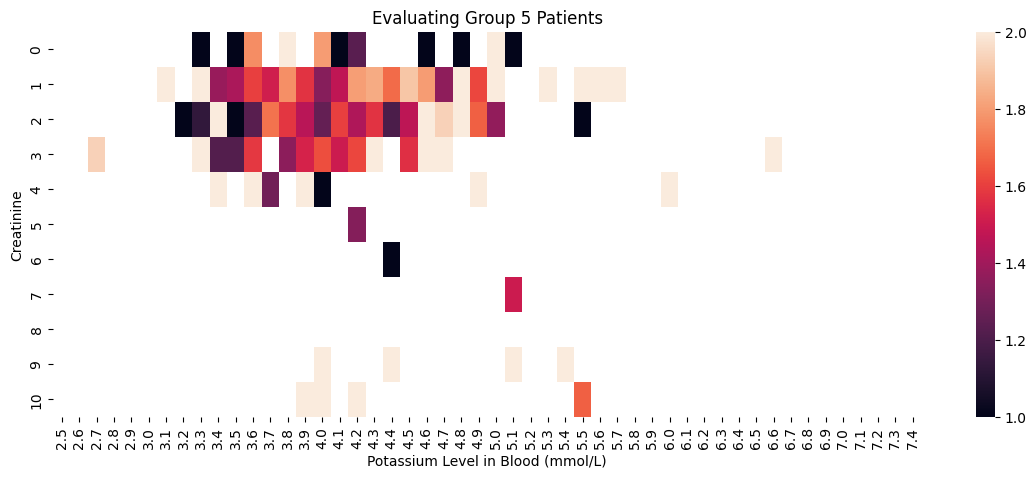

In [162]:
plt.figure(figsize=(14, 5))
sns.heatmap(viz, xticklabels=measurements, yticklabels=ages)
plt.ylabel("Creatinine")
plt.xlabel("Potassium Level in Blood (mmol/L)")
plt.title("Evaluating Group 5 Patients")
plt.savefig(grouppp+ "patients.png")